## Importar bibliotecas

In [1]:
import gurobipy as gp
from gurobipy import GRB
import itertools
import math

# TSP

Dado um grafo completo $G=(V,A)$ em que cada aresta $(i,j) \in A$ tem um custo $d_{ij}$, determinar o ciclo hamiltoniano de custo mínimo.

O problema pode ser modelado por programação linear inteira.

Variáveis de decisão:

* $x_{ij}$: variável binária que indica se a aresta $(i,j) \in A$ faz parte ou não da rota ótima

Minimizar $\sum_i\sum_j d_{ij}x_{ij}$

sujeito a:

$\sum_{i:i \neq j} x_{ij} = 1, \forall j \in \{1,2,...,n\}$

$\sum_{j:i \neq j} x_{ij} = 1, \forall i \in \{1,2,...,n\}$

$x_{ij} \in \{0,1\}, \forall i \in \{1,2,...,n\}, j \in \{1,2,\dots,n\}$

onde:

A função objetivo minimiza o custo total das arestas escolhidas. As restrições garantem que, para cada vértice, seja escolhida uma aresta chegando e uma saindo.

No entanto, o modelo com essas restrições não garante uma rota única. Por exemplo, em um problema com 6 vértices, uma solução com $x_{12}, x_{23}, x_{31}, x_{45}, x_{56}, x_{64}$ valendo 1 e todas as demais valendo 0 atende às restrições (uma aresta chegando e uma saindo de cada vértice) mas representa dois subciclos $1 \rightarrow 2 \rightarrow 3 \rightarrow 1$ e $4 \rightarrow 5 \rightarrow 6 \rightarrow 4$, não um ciclo hamiltoniano.

Isso pode ser resolvido acrescentando-se variáveis e/ou restrições adicionais, como nas formulações propostas por: Dantzig, Fulkerson e Johnson, com eliminação de subtours; Miller, Tucker e Zemlin (MTZ), que enumera os vértices; Gavish e Graves, com fluxo.

## Gerar matriz de distancias a partir de pontos

In [2]:
def distMatriz(points,n): #calcula a matriz de distancias ao quadrado
    d = [[0] * n for i in range(n)]
    for i in range(n):
        for j in range (i+1,n):
            x1, y1 = points[i]
            x2, y2 = points[j]
            dist = (x1-x2)*(x1-x2) + (y1-y2)*(y1-y2)
            d[i][j] = d[j][i] = dist
    return d

**Formulação Dantzig–Fulkerson–Johnson**

Para cada subconjunto $S \subset V$, o número de arestas entre vértices de $S$ deve ser no máximo $|S|-1$, o que impede um subciclo fechado entre os vértices de $S$.

O modelo ILP completo é então:

Minimizar $\sum_i\sum_j d_{ij}x_{ij}$

sujeito a:

$\sum_{i:i \neq j} x_{ij} = 1, \forall j \in \{1,2,...,n\}$

$\sum_{j:i \neq j} x_{ij} = 1, \forall i \in \{1,2,...,n\}$

$\sum_{i \in S} \sum_{j \in S: j \neq i} x_{ij} \leq |S| -1, \forall S \subset V$

$x_{ij} \in \{0,1\}, \forall i \in \{1,2,...,n\}, j \in \{1,2,\dots,n\}$

A restrição acrescentada impede formação de subciclos, portanto a solução é um ciclo hamiltoniano, solução válida para o TSP. No entanto, o número de restrições acrescentadas é exponencial (cerca de $2^n$).

Copiei esse modelo no ChatGPT e ele me gerou esse código aí:

In [4]:
def  DFJ(distances, n):
    model= gp.Model("DFJ")
    x = {} #variavel de decisao
    for i in range(n):
        for j in range(n):
            x[i,j] = model.addVar(lb = 0,vtype=GRB.BINARY, name = f'x_{i}_{j}')
    
    #retrições iniciais
    for i in range(n):
        model.addConstr(gp.quicksum(x[i,j] for j in range(n) if i != j) == 1, name = f'demand_1_x_{i}_{j}')
    
    for j in range(n):
        model.addConstr(gp.quicksum(x[i,j] for i in range(n) if i != j) == 1, name = f'demand_2_x_{i}_{j}')
    
    #restrição de subciclos de Dantzig–Fulkerson–Johnson
    #já gerando todos os subciclos
    for size in range(2,n):
        for subset in itertools.combinations(range(n),size):
            model.addConstr(gp.quicksum(x[i,j] for i in subset for j in subset if i != j) <=size-1)
    
    #função de avaliação
    model.setObjective(gp.quicksum(distances[i][j]*x[i,j] for i in range(n) for j in range(n)), GRB.MINIMIZE)
    
    
    return model, x

## Formulação Miller-Tucker-Zemlin (MTZ)

$ Variáveis $

$x_{ij}={\begin{cases}1&{\text{o caminho vai da cidade}}i{\text{ para cidade }}j\\0&{\text{caso contrário}}\end{cases}}$

$u_i= \text{mantém o controle da ordem em que as cidades são visitadas, contando a partir da cidade 1} $ 


\begin{equation*}
\begin{aligned}
& \underset{}{\text{Minimizar}}
& & \sum_{i=1}^{n} \sum_{j=1, j\neq i}^{n} c_{ij} x_{ij} \\
& \text{Sujeito a}
& & \sum_{j=1, j\neq i}^{n} x_{ij} = 1, \quad i = 1,\ldots,n, \\
& 
& & \sum_{i=1, i\neq j}^{n} x_{ij} = 1, \quad j = 1,\ldots,n, \\
& 
& &  u_i + x_{ij} \leq u_j + (n-1) * (1-x_{ij} ) \quad i = 1,\ldots,n, \quad j = 2,\ldots,n,  \\ 
&
& & x_{ij} \in \{0,1\}, \quad i,j = 1,\ldots,n, \, i\neq j, \\
&
& & u_i \in \mathbb{R}^+
\end{aligned}
\end{equation*}


In [5]:
def  MTZ(distances, n):
    model= gp.Model("MTZ")
    x = {} #variavel de decisao
    for i in range(n):
        for j in range(n):
            x[i,j] = model.addVar(lb = 0,vtype=GRB.BINARY, name = f'x_{i}_{j}')
            
    u = {}
    
    for i in range(n):
        u[i] = model.addVar(lb = 0, ub = n-1, vtype = GRB.CONTINUOUS, name = f'u_{i}')
    
    #retrições iniciais
    for i in range(n):
        model.addConstr(gp.quicksum(x[i,j] for j in range(n) if i != j) == 1, name = f'demand_1_x_{i}_{j}')
    
    for j in range(n):
        model.addConstr(gp.quicksum(x[i,j] for i in range(n) if i != j) == 1, name = f'demand_2_x_{i}_{j}')
        
    
    #restrição de subciclos de Miller-Tucker-Zemlin (MTZ)
    for i in range(n):
        for j in range(1, n):
            if i != j:
                model.addConstr( u[i] + x[i,j] <= u[j] + (n - 1) * (1 - x[i, j]) , name = f'demand_u_{i}_{j}')
    
    #função de avaliação
    model.setObjective(gp.quicksum(distances[i][j]*x[i,j] for i in range(n) for j in range(n)), GRB.MINIMIZE)
    
    
    return model, x

## Formulação Gavish–Graves (GG)

$ Variáveis $

$x_{ij}={\begin{cases}1&{\text{o caminho vai da cidade}}i{\text{ para cidade }}j\\0&{\text{caso contrário}}\end{cases}}$

$g_{ij}= \text{O número de arcos no caminho do vértice 1 ao arco (i, j) no passeio ideal} $ 


\begin{equation*}
\begin{aligned}
& \underset{}{\text{Minimizar}}
& & \sum_{i=1}^{n} \sum_{j=1, j\neq i}^{n} c_{ij} x_{ij} \\
& \text{Sujeito a}
& & \sum_{j=1, j\neq i}^{n} x_{ij} = 1, \quad i = 1,\ldots,n, \\
& 
& & \sum_{i=1, i\neq j}^{n} x_{ij} = 1, \quad j = 1,\ldots,n, \\
& 
& & \sum_{j=1}^n g_{ji} - \sum_{j=2}^n g_{ij} = 1, \quad i = 1,\ldots,n,\\
&
& & 0 \leq g_{ij} \leq ( n - 1 ) x_{ij}, \quad j = 2,\ldots,n,\\
&
& & x_{ij} \in \{0,1\}, \quad i,j = 1,\ldots,n, \, i\neq j, \\
&
& & g_{ij} \ge 0, \quad i, j = 1,\ldots,n,\, i\neq j. \\
\end{aligned}
\end{equation*}


In [6]:
def  GG(distances, n):
    model= gp.Model("GG")
    x = {} #variavel de decisao
    for i in range(n):
        for j in range(n):
            x[i,j] = model.addVar(lb = 0,vtype=GRB.BINARY, name = f'x_{i}_{j}')
            
    g = {}
    for i in range(n):
        for j in range(n):
            if i!=j:
                g[i,j] = model.addVar(lb=0.0, vtype=GRB.CONTINUOUS, name = f'g_{i}_{j}')
    
    #retrições iniciais
    for i in range(n):
        model.addConstr(gp.quicksum(x[i,j] for j in range(n) if i != j) == 1, name = f'demand_1_x_{i}_{j}')
    
    for j in range(n):
        model.addConstr(gp.quicksum(x[i,j] for i in range(n) if i != j) == 1, name = f'demand_2_x_{i}_{j}')
        
    
    #restrição de subciclos de Gavish–Graves (GG)
    
    for i in range(n):
        model.addConstr(gp.quicksum(g[j, i] for j in range(n) if(i!=j)) - gp.quicksum(g[i, j] for j in range(1, n) if(i!=j) ) == 1,
                        name=f'demand_g_{i}')
        
    for i in range(n):
        for j in range(1,n):
            if(i!=j):
                model.addConstr(g[i,j] <=(n-1)*x[i,j] , name = f'restrict_g_{i}_{j}')
    
    
    #função de avaliação
    model.setObjective(gp.quicksum(distances[i][j]*x[i,j] for i in range(n) for j in range(n)), GRB.MINIMIZE)
    
    
    return model, x

## Main

## Print caminho

In [7]:
def printModel(model, x):
    res = 0.0
    if model.status == GRB.OPTIMAL:
        print('Solução ótima encontrada:')
        for i in range(n):
            for j in range(n):
                if x[i,j].x > 0.5:
                    print(f'Aresta ({i}, {j}) faz parte do caminho hamiltoniano')
                    res += dist[i][j]
    else:
        print('Não foi possível encontrar uma solução ótima')
    print(res)

In [8]:
def processar_arquivo(nome_arquivo):
    # Abre o arquivo em modo de leitura
    with open(nome_arquivo, 'r') as arquivo:
        # Lê a quantidade de linhas do arquivo
        num_linhas = int(arquivo.readline())

        # Inicializa o array de tuplas
        tuplas = []

        # Itera sobre as linhas do arquivo
        for _ in range(num_linhas+1):
            # Lê a linha e remove espaços em branco à direita
            linha = arquivo.readline().rstrip()

            # Divide a linha em colunas usando espaços em branco como delimitadores
            colunas = linha.split()

            # Verifica se a linha contém pelo menos três colunas
            if len(colunas) >= 3:
                # Converte os valores de b e c para float e adiciona à lista de tuplas
                tuplas.append((float(colunas[1]), float(colunas[2])))
#                 print(float(colunas[1]), float(colunas[2]))
#             else:
#                 print(f"A linha '{linha}' não contém o número esperado de colunas.")

    return tuplas

In [9]:
coordenadas = []

coordenadas = processar_arquivo("instancias/gr431.tsp")

n = len(coordenadas)
# n = 11

dist = distMatriz(coordenadas, n)
# for i in range (n):
#     for j in range(n):
#         print(dist[i][j], end = " ")
#     print()


In [17]:
model, x = DFJ(dist, n)

model.optimize()

# printModel(model, x)

KeyboardInterrupt: 

In [28]:
model, x = MTZ(dist, n)
# parou no gr202

model.optimize()

# printModel(model, x)

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Core(TM) i7-8565U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 40805 rows, 41006 columns and 202407 nonzeros
Model fingerprint: 0xeb92de2b
Variable types: 202 continuous, 40804 integer (40804 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [2e-03, 1e+04]
  Bounds range     [1e+00, 2e+02]
  RHS range        [1e+00, 2e+02]
Presolve removed 0 rows and 203 columns
Presolve time: 0.39s
Presolved: 40805 rows, 40803 columns, 202206 nonzeros
Variable types: 201 continuous, 40602 integer (40602 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 2.591386e+03, 779 iterations, 0.37 seconds (0.17 work units)

    Nodes    |    Current Node    |     Objective

  4823  2645 5637.70038   47  222 5737.65140 5637.68430  1.74%  40.2  416s
H 4825  2513                    5733.3742000 5637.68430  1.67%  40.2  416s
  4873  2563 5642.52879   53  231 5733.37420 5637.68430  1.67%  40.3  420s
H 4900  2433                    5731.8522000 5637.68430  1.64%  40.2  422s
H 4901  2314                    5729.9862000 5637.68430  1.61%  40.2  422s
  4922  2340 5642.73455   63  132 5729.98620 5637.68430  1.61%  40.2  425s
  4998  2381 5643.78238   76  221 5729.98620 5637.68430  1.61%  40.3  430s
  5067  2420 5698.67764   88  219 5729.98620 5637.68430  1.61%  40.4  443s
H 5085  2302                    5728.4918000 5637.68430  1.59%  40.6  443s
  5086  2319 5700.69752   90  207 5728.49180 5637.68430  1.59%  40.6  445s
  5137  2346 infeasible   96      5728.49180 5637.68430  1.59%  40.9  450s
  5247  2375 5639.47568   55  128 5728.49180 5637.68430  1.59%  40.8  457s
  5292  2406 5652.74164   63  280 5728.49180 5637.68430  1.59%  40.8  460s
  5383  2452 5654.57494  

In [10]:
model, x = GG(dist, n)
# parou no gr431

model.optimize()

# printModel(model, x)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-05
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Core(TM) i7-8565U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 186193 rows, 371091 columns and 1110690 nonzeros
Model fingerprint: 0x891e6ae3
Variable types: 185330 continuous, 185761 integer (185761 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+02]
  Objective range  [2e-03, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 1 rows and 861 columns
Presolve time: 3.25s
Presolved: 186192 rows, 370230 columns, 1109830 nonzeros
Variable types: 184900 continuous, 185330 integer (185330 binary)
Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Root barrier log...

Ordering time: 0.13s

Barrier statistics:
 AA

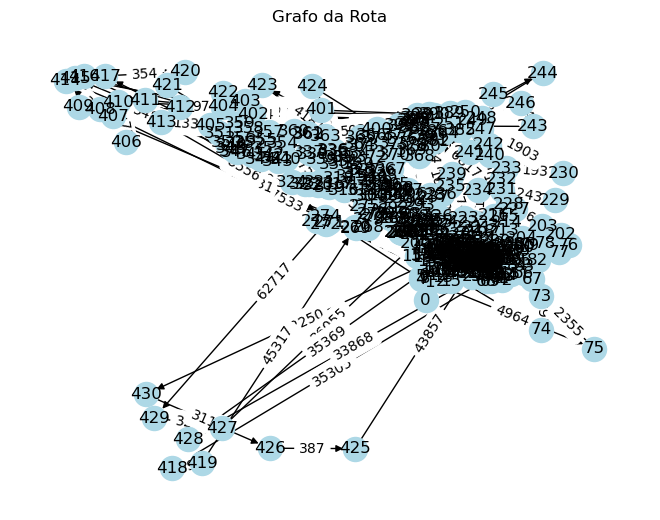

Não foi possível encontrar uma solução ótima
0.0


In [11]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()
for i in range(n):
    G.add_node(i)
for i in range(n):
    for j in range(n):
        if x[i, j].x > 0.5:
            G.add_edge(i, j)

pos = {i: coordenadas[i] for i in range(n)}
nx.draw(G, pos, with_labels=True, node_size=300, node_color='lightblue')
labels = {(i, j): int(dist[i][j]) for i in range(n) for j in range(n) if x[i, j].x > 0.5}
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title("Grafo da Rota")
plt.show()

# Imprimir a rota
printModel(model, x)